## Customer Churn Prediction Project
This project aims to predict customer churn for a telecom company using machine learning techniques. 
The dataset contains customer information, usage patterns, and contract details. 
The goal is to identify at-risk customers and suggest retention strategies.

In [11]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for machine learning and data preparation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Telecom.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
print(df.duplicated().sum())

0


In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [8]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
# since only 11 rows have NAN value of TotalCharges I drop the rows
df = df.dropna()


### Exploratory Data Analysis (EDA) for Customer Churn Prediction

#### Objective:
The primary goal of this EDA is to:
- Understand the structure and characteristics of the dataset.
- Identify patterns, trends, and relationships between features.
- Detect and handle missing values, outliers, and inconsistencies.
- Formulate hypotheses that may help in building an effective predictive model.

#### Dataset Overview:
- The dataset contains 21 columns and includes customer information, service details, and churn status.
- Key features include `Contract`, `MonthlyCharges`, `Tenure`, and `InternetService`.
- The target variable is `Churn`, indicating whether a customer has left the company.


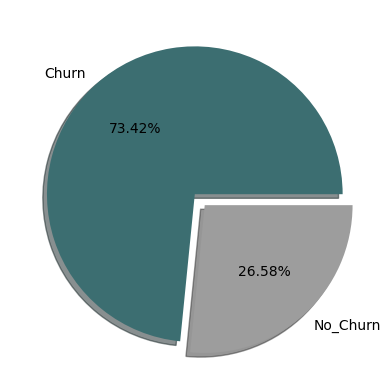

In [12]:
# Understanding Churn Rate
plt.pie(x= df['Churn'].value_counts().values, labels=['Churn','No_Churn'], autopct="%.2f%%", explode=[0, 0.1],
        colors=['#3c6e71','#9d9d9d'], shadow=True)
plt.show()

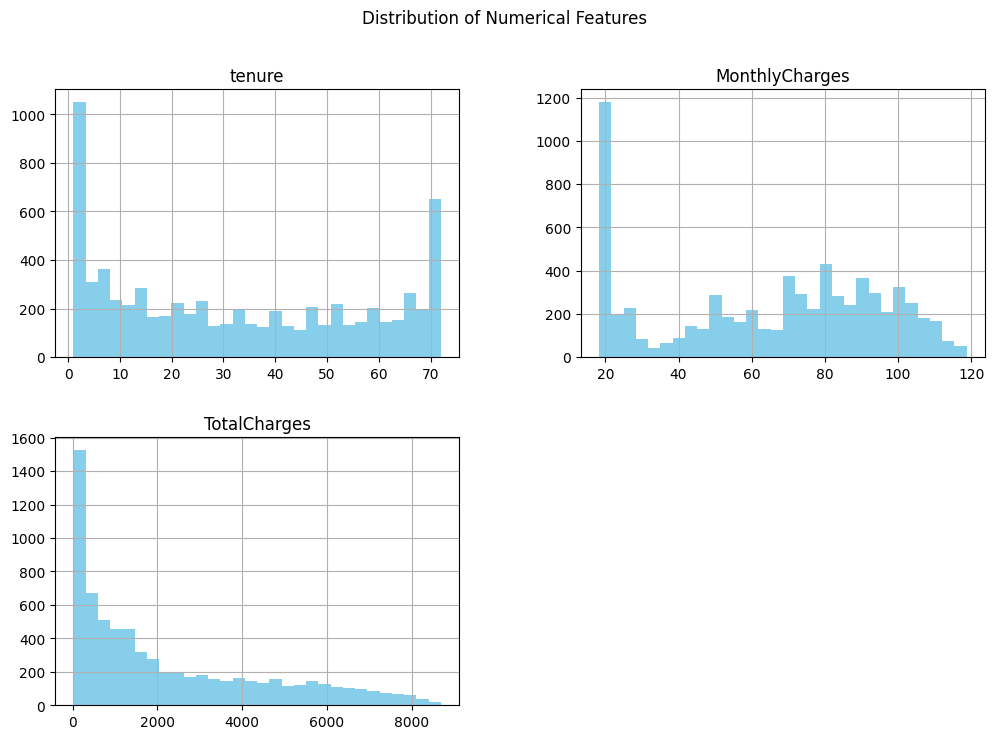

In [14]:
#Data distribution in numerical columns
num_cols = ['tenure','MonthlyCharges','TotalCharges']
df[num_cols].hist(bins=30, figsize=(12,8), color='skyblue')
plt.suptitle('Distribution of Numerical Features')
plt.show()

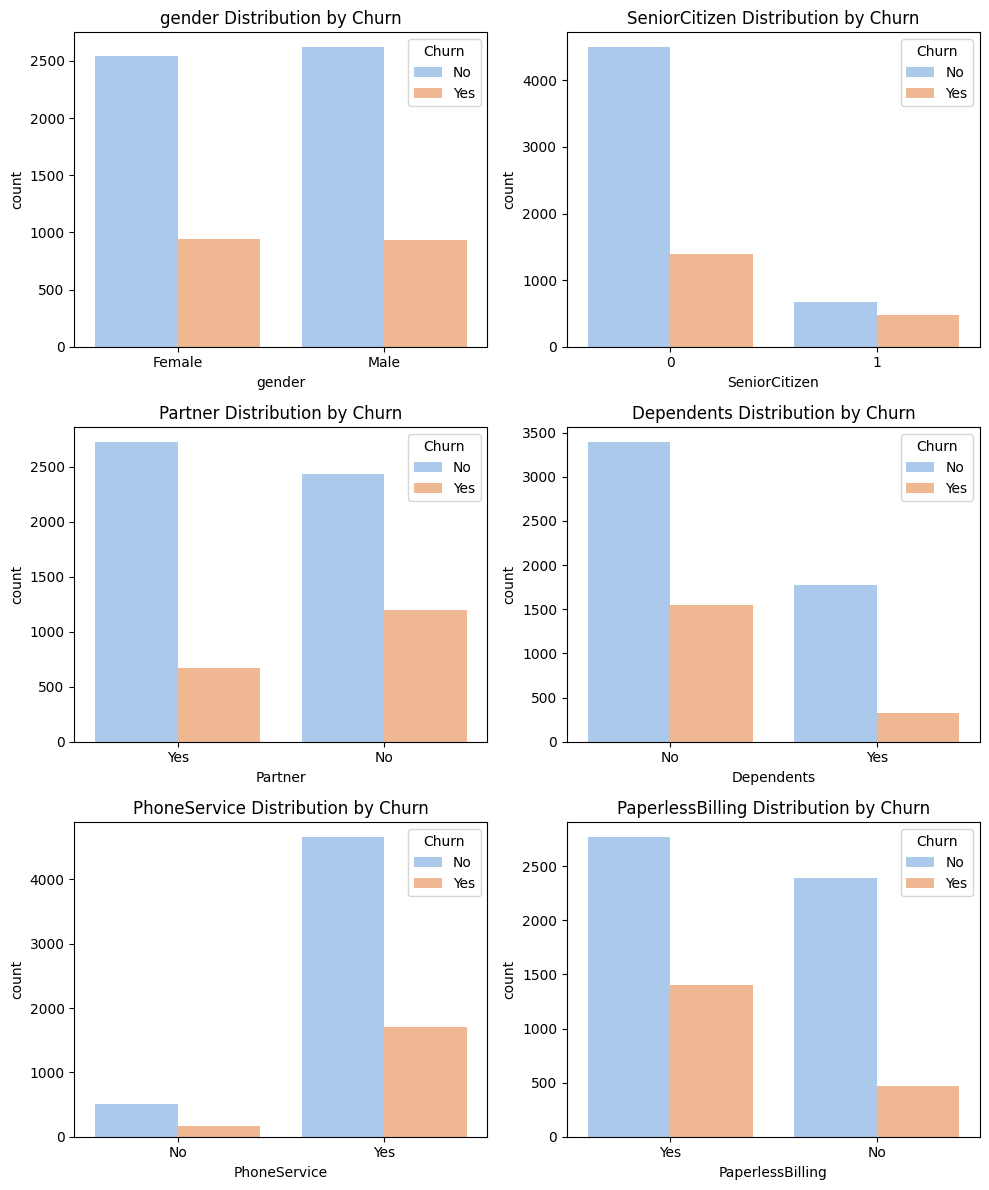

In [15]:
# Distribution of Categorical columns with binary values by Churn

binary_cols = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','PaperlessBilling']
fig, axes= plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()
for i, col in enumerate(binary_cols):
    sns.countplot(x=col, ax=axes[i], palette='pastel', hue='Churn', data=df)
    axes[i].set_title(f'{col} Distribution by Churn')

plt.tight_layout()
plt.show()

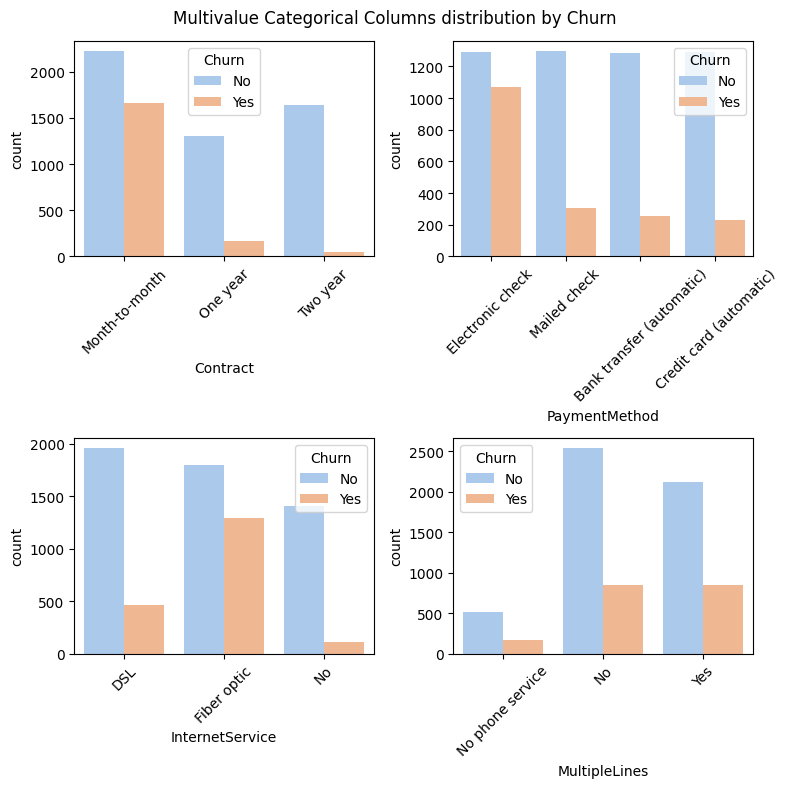

In [16]:
# Data distribution of categorical columns with multiple values by Churn
multi_cols= ['Contract','PaymentMethod','InternetService','MultipleLines']

fig, axes= plt.subplots(2, 2, figsize=(8,8))
axes=axes.flatten()
for i, col in enumerate(multi_cols):
    sns.countplot(x=col, data=df, palette='pastel', ax=axes[i], hue='Churn')
    plt.suptitle('Multivalue Categorical Columns distribution by Churn')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

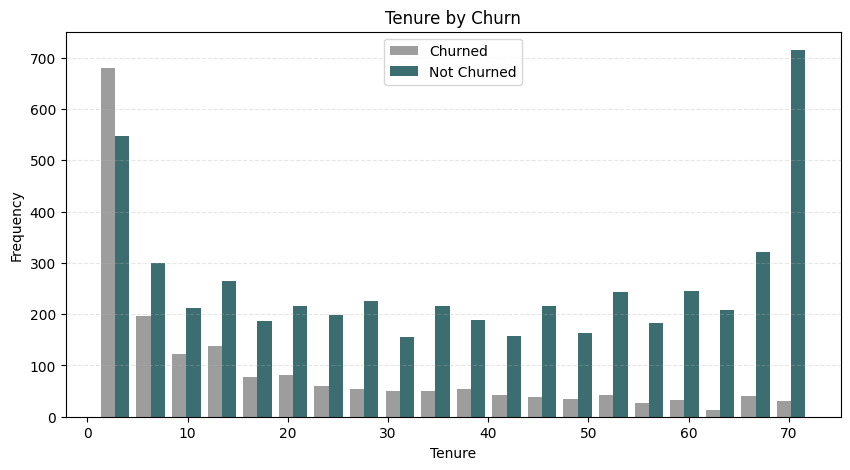

In [20]:
# visualizing tenure by Churn

churned =df[df['Churn']=='Yes']
not_churned = df[df['Churn'] =='No']

plt.figure(figsize=(10,5))
plt.hist([churned['tenure'], not_churned['tenure']], bins=20, label=['Churned','Not Churned'], color=['#9d9d9d','#3c6e71'])
plt.title('Tenure by Churn')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

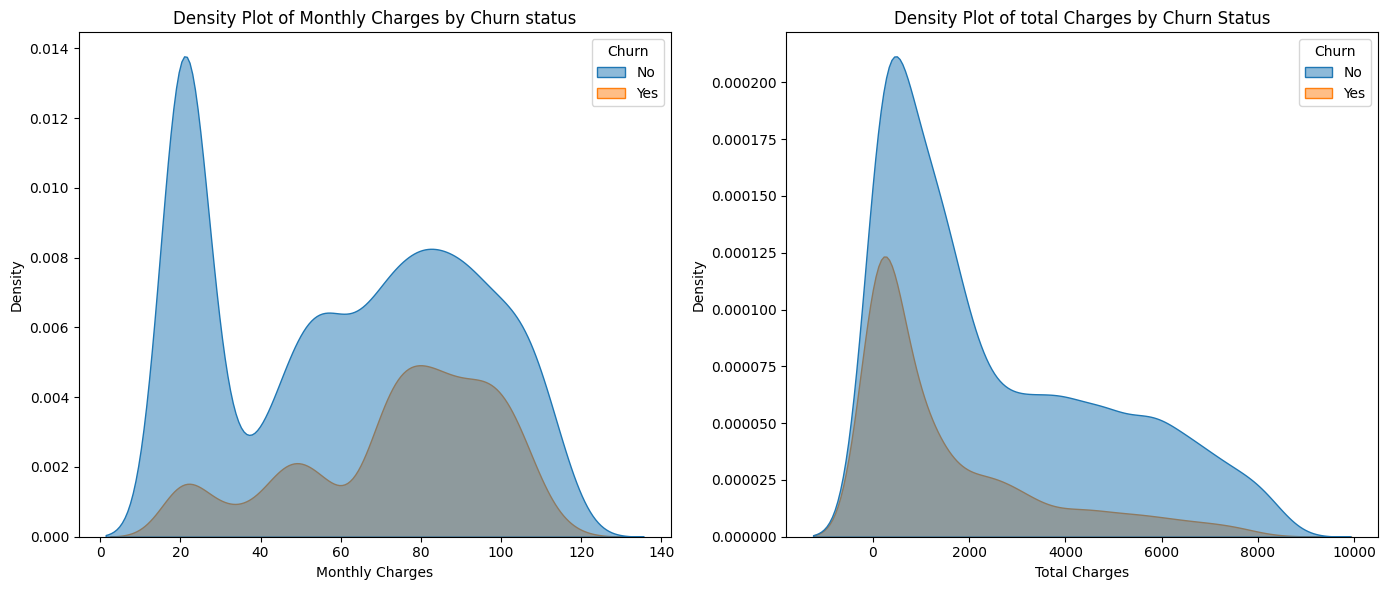

In [21]:
#Visualizes the impact of Monthly and TotalCharges on churn to identify pricing related churn patterns.
fig, axes= plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Density Plot of Monthly Charges by Churn status')
axes[0].set_xlabel('Monthly Charges')
axes[0].set_ylabel('Density')

# for total Charges
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Density Plot of total Charges by Churn Status')
axes[1].set_xlabel('Total Charges')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

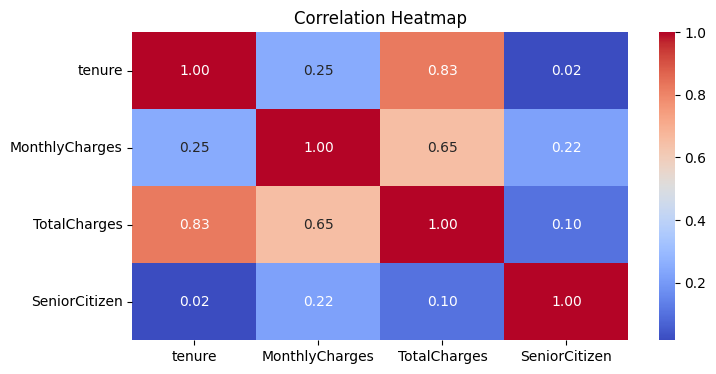

In [22]:
# Correlation matrix - heatmap 
plt.figure(figsize=(8,4))
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges','SeniorCitizen']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [23]:
bins = [0, 30, 70, df['MonthlyCharges'].max()]
labels= ['Low','Mid','High']
df['MonthlyCharges_Category'] = pd.cut(df['MonthlyCharges'], bins=bins, labels=labels)


In [24]:
# Label encoding of target Column
df['Churn'] = df['Churn'].replace({'Yes':1, 'No':0})


#### Key Insights from EDA
EDA revealed that contract type, tenure, and payment method were strongly correlated with customer churn. Customers with month-to-month contracts and electronic check payment methods had a significantly higher churn rate compared to long-term contract holders.

### Label encoding of categorical features

In [25]:
df['MonthlyCharges_Category'] = df['MonthlyCharges_Category'].replace({'Low':0, 'Mid':1,'High':2})

In [26]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [27]:
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_Category
0,0,0,1,0,1,0,1,0,0,2,...,0,0,0,0,1,2,29.85,29.85,0,0
1,1,0,0,0,34,1,0,0,2,0,...,0,0,0,1,0,3,56.95,1889.50,0,1
2,1,0,0,0,2,1,0,0,2,2,...,0,0,0,0,1,3,53.85,108.15,1,1
3,1,0,0,0,45,0,1,0,2,0,...,2,0,0,1,0,0,42.30,1840.75,0,1
4,0,0,0,0,2,1,0,1,0,0,...,0,0,0,0,1,2,70.70,151.65,1,2


In [28]:
#Scalling 
scaler = StandardScaler()
df[['tenure','MonthlyCharges','TotalCharges']] = scaler.fit_transform(df[['tenure','MonthlyCharges','TotalCharges']])


### Training and test data split


In [30]:
#splitting the features and target
X = df.drop(columns=['Churn'])
y = df["Churn"]

### `Model Training with Original data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
#Feature Scalling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
models= {
    "Random Forest": RandomForestClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": SVC(random_state=42, probability=True),
    "XGBClassifier": XGBClassifier(random_state=42)
}

In [42]:
results = []

# Train models and store results
print('Results of original data')
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC-ROC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    print('-'*50)


    #Append results on the list
    results.append([name, accuracy, 'Original'])

Results of original data
Random Forest - Accuracy: 0.7861, AUC-ROC: 0.6846
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.77      1407

--------------------------------------------------
DecisionTreeClassifier - Accuracy: 0.7171, AUC-ROC: 0.6504
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1033
           1       0.47      0.51      0.49       374

    accuracy                           0.72      1407
   macro avg       0.64      0.65      0.65      1407
weighted avg       0.72      0.72      0.72      1407

--------------------------------------------------
Logistic Regression - Accuracy: 0.7882, AUC-ROC: 0.6946
              precision    recall  f1-score   support


In [36]:
# Since we did not achieve the require accuracy. Therefore, we use some feature engineering to increase the model performance
# Handling Imbalanced Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)

In [37]:
#Splitting data into train and test
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=42)


In [38]:
#Feature Scalling
scaler= StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test_smote = scaler.transform(X_test_smote)

In [39]:
print(y_train_smote.value_counts())

Churn
1    4134
0    4126
Name: count, dtype: int64


Now, the class is balanced we can train the model to get better results

In [41]:
from sklearn.impute import SimpleImputer

# Create an imputer to replace NaN with the mean of the column
imputer = SimpleImputer(strategy='mean')

#Fit the imputer on the training data and transform both train and test data
X_train_smote = imputer.fit_transform(X_train_smote)
X_test_smote = imputer.transform(X_test_smote)

In [43]:
# Training and Evaluating Models on SMOTE data
print('Results on SMOTE Data')
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test_smote)
    accuracy_smote = accuracy_score(y_test_smote, y_pred_smote)
    roc_auc_smote = roc_auc_score(y_test_smote, model.predict_proba(X_test_smote)[:,1])
    print(f"{name} -Accuracy: {accuracy_smote:.4f}, AUC-ROC: {roc_auc_smote:.4f}")
    print(classification_report(y_test_smote, y_pred_smote))
    print('-'*50)

    # Append the results 
    results.append([name, accuracy_smote, 'SMOTE'])

Results on SMOTE Data
Random Forest -Accuracy: 0.8398, AUC-ROC: 0.9123
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1037
           1       0.82      0.87      0.84      1029

    accuracy                           0.84      2066
   macro avg       0.84      0.84      0.84      2066
weighted avg       0.84      0.84      0.84      2066

--------------------------------------------------
DecisionTreeClassifier -Accuracy: 0.7609, AUC-ROC: 0.7613
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1037
           1       0.75      0.78      0.76      1029

    accuracy                           0.76      2066
   macro avg       0.76      0.76      0.76      2066
weighted avg       0.76      0.76      0.76      2066

--------------------------------------------------
Logistic Regression -Accuracy: 0.7914, AUC-ROC: 0.8638
              precision    recall  f1-score   support

     

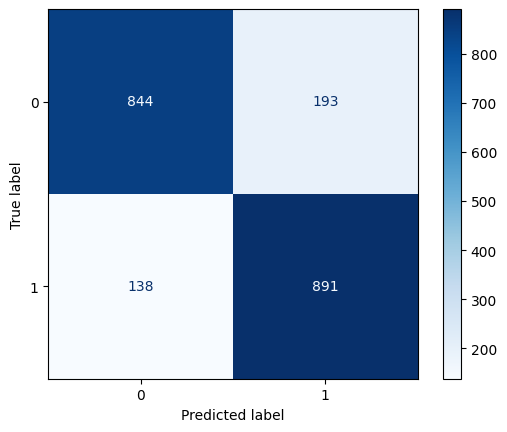

In [44]:
# Creating the confustion matrix for best performing model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_smote, y_train_smote)
y_pred = rfc.predict(X_test_smote)
cm = confusion_matrix(y_test_smote, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=pld.cm.Blues)
plt.show()

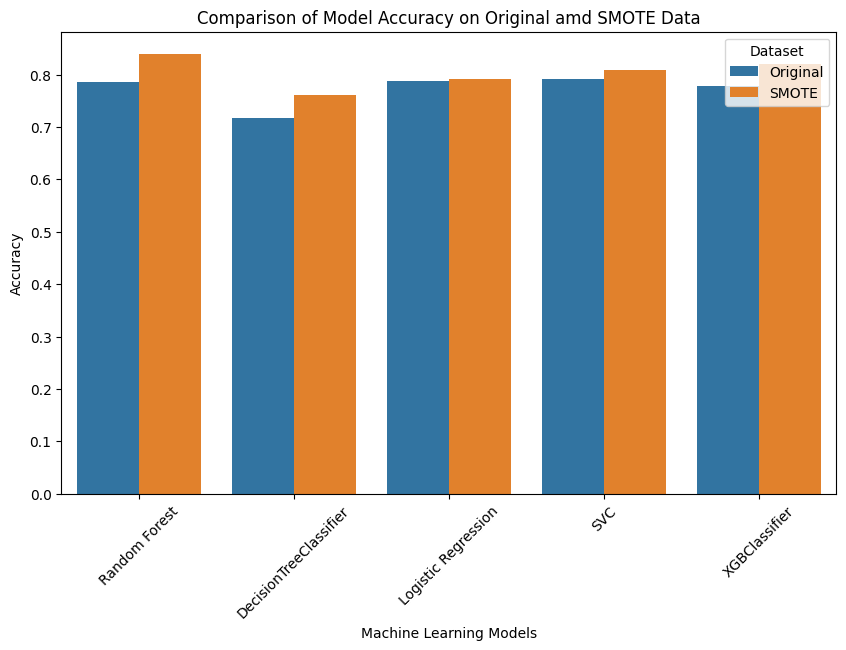

In [45]:
# Create the Dataframe for the evaluation results of different models
results_df = pd.DataFrame(results, columns=['Model','Accuracy','Dataset'])

# Visualization of Model Accuracy
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=results_df)
plt.xticks(rotation=45)
plt.title('Comparison of Model Accuracy on Original amd SMOTE Data')
plt.ylabel('Accuracy')
plt.xlabel('Machine Learning Models')
plt.legend(title='Dataset')
plt.show()

##### Model Evaluation Results
Several models were evaluated, including Logistic Regression, Random Forest, and XGBoost. The best-performing model was Random Forest, achieving an accuracy of 84%, a precision of 82%, with an AUC_ROC score of 0.91. This balance precision and recall ensures that the model can effectively identify customers at risk of churning.

### Conculsion
The churn prediction model successfully identified high-risk customers using 21 features related to customer demagraphics, subscription types, and payment methods. EDA highlighted that contract type and payment methods were significant drivers of churn.

#### Key Insights 
* Customers with month-to-month contracts are more likely to churn.
* Higher monthly charges also increase the likelihood of churn.
* Customer who uses Fiber Optic is likely to churn.
* Payment method preferences impact customer retention.
  